In [1]:
%load_ext autoreload
%autoreload 2

# TUNED | RANDOM FOREST | LOW MULTICOLLINEARITY

MAX VIF ~ 6 with "PLTH"

VIF < 5, else

In [2]:
import sys
sys.path.append('../../')
import tokamakTK

import pydotplus
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import statsmodels.api as sm
import matplotlib.patches as mpatches

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, precision_recall_fscore_support

pd.set_option('display.max_columns', None)
path = "../../data/"
fig_path = "../../../../LATEX/Latex Images/"

In [3]:
# Obtained from Optimization

min_subset_ids = pd.read_csv(path+"R_ids_alpha_0.6357.csv")

DB2 = pd.read_csv(path+"DB2P8.csv")
DB5 = pd.read_csv(path+"SELDB5_SVD.csv", low_memory=False) 

# Setting ELMy Dataset
DB5 = DB5[DB5["PHASE"].isin(['HGELM', 'HSELM', 'HGELMH', 'HSELMH'])]

# REMOVING SPHERICAL TOKAMAKS
DB5 = DB5[~DB5.TOK.isin(['MAST', 'NSTX', 'START'])]


# There is two shots from DB2P8 missing in DB5
missing_shots = DB2[~DB2.id.isin( DB5.id.values )].reset_index(drop=True)
DB5 = pd.concat([DB5, missing_shots], axis=0, ignore_index=True)

# Labeling shots that had great impact in decreasing alpha_R
DB5.insert(loc=2,column="label",value=[0]*len(DB5))
DB5.loc[(DB5[DB5.id.isin(min_subset_ids.id)].index), "label"] = 1


print(
    f"{ round( (len(min_subset_ids)/len(DB5))*100     ,2)  }% of the data decreased alpha_R\n" + 
    f"{ round( (1 - len(min_subset_ids)/len(DB5))*100 ,2)  }% of the data did not decrease alpha_R"
)

24.37% of the data decreased alpha_R
75.63% of the data did not decrease alpha_R


Class distribution can be considered is skewed.

## Treatment to Categorical and Numerical Data

```Python
# MAX VIF ~ 6 with "PLTH"
#VIF < 5, else

features = ['BETASTAR','BT','DWDIA','ENBI','HYBRID','IP','KAREA','LHTIME',
            'MEFF','NEL','NUSTAR','PECRH','PFLOSS','PICRH','PLTH','POHM','PRAD',
            'Q95','RHOSTAR','TAV','WFICFORM']

# n_estimators = 93, max_depth=20
(array([0.87267905, 0.94047619]),
 array([0.79468599, 0.96549245]),
 array([0.83185841, 0.95282015]),
 array([ 414, 1391]))

#['RHOSTAR', 'TAV', 'NUSTAR', 'LHTIME', 'BETASTAR'] | Impurity
#['RHOSTAR', 'TAV', 'LHTIME', 'BETASTAR', 'NUSTAR'] | Permutation

# ---------------------------------------------------------------------------------

# MAX VIF ~ 4.5 with "RHOSTAR"

features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']

# n_estimators = 93, max_depth=20
(array([0.89095745, 0.94471659]),
 array([0.80917874, 0.9705248 ]),
 array([0.84810127, 0.95744681]),
 array([ 414, 1391]))
# ['RHOSTAR', 'TAV', 'NUSTAR', 'LHTIME', 'BETASTAR'] | Impurity
# ['RHOSTAR', 'TAV', 'LHTIME', 'BETASTAR', 'NUSTAR'] | Permutation
```

In [4]:
features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']

In [5]:
DB5 = tokamakTK.clean_categorical_data(DB5)

# Needed to respectively clean each dtype
num_features = DB5[features].select_dtypes(include=['int', 'float']).columns.tolist()
cat_features = DB5[features].select_dtypes(include=['object']).columns.tolist()

data_num = DB5[num_features+["TOK","DATE"]]
data_cat = DB5[cat_features]

data_num = tokamakTK.clean_numerical_data(data_num)

data_ = pd.concat([data_num,
                  (pd.concat([
                       DB5[["label"]], 
                       tokamakTK.encode_categorical_ohe(data_cat)
                      ], axis=1)
                  )],
                  axis=1
                 )

In [6]:
X = data_.drop("label", axis=1)
y = data_["label"]

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=71, stratify=y)

In [7]:
# Define random forest classifier with preprocessor as a pipeline
rf = RandomForestClassifier(min_samples_split=2,  
                            min_samples_leaf=1,
                            min_impurity_decrease=0.0007,
                            n_estimators = 93,
                            max_depth = 20,
                            criterion='entropy',
                            max_features=None,
                            random_state=71,
                            n_jobs=-1,
                           )
"""
    features = ['BETASTAR','BT','DWDIA','ENBI','HYBRID','IP','KAREA','LHTIME',
            'MEFF','NEL','NUSTAR','PECRH','PFLOSS','PICRH','PLTH','POHM','PRAD',
            'Q95','RHOSTAR','TAV','WFICFORM']

entropy
(array([0.87267905, 0.94047619]),
 array([0.79468599, 0.96549245]),
 array([0.83185841, 0.95282015]),
 array([ 414, 1391]))
 
gini
(array([0.88150289, 0.9252913 ]),
 array([0.73671498, 0.9705248 ]),
 array([0.80263158, 0.94736842]),
 array([ 414, 1391]))
 
It would be nice to compare best features with gini vs entropy
 
log_loss
(array([0.87267905, 0.94047619]),
 array([0.79468599, 0.96549245]),
 array([0.83185841, 0.95282015]),
 array([ 414, 1391]))
 
     features = ['AUXHEAT','BETASTAR','BT','DIVNAME','ECHMODE','ELMFREQ','ELMTYPE',
            'ENBI','HYBRID','IP','KAREA','LHTIME','MEFF','NUSTAR','PECRH',
            'PELLET','PNBI','POHM','PREMAG','Q95','RHOSTAR',
            'TAV','TEV','TORQ','WFFORM','ZEFFNEO']
entropy
(array([0.88739946, 0.94203911]),
 array([0.79951691, 0.9698059 ]),
 array([0.841169  , 0.95572086]),
 array([ 414, 1391]))

gini
(array([0.89014085, 0.93241379]),
 array([0.76328502, 0.97196262]),
 array([0.82184655, 0.95177754]),
 array([ 414, 1391]))
 
log_loss
(array([0.88739946, 0.94203911]),
 array([0.79951691, 0.9698059 ]),
 array([0.841169  , 0.95572086]),
 array([ 414, 1391]))
"""


rf.fit(X_train, y_train)
y_pred= rf.predict_proba(X_test)

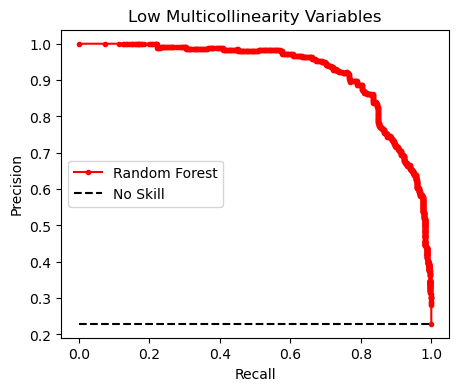

In [8]:
plt.figure(figsize=(5,4))

# keep probabilities for the positive outcome only
y_pred = y_pred[:, 1]
# calculate pr-curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
# plot the roc curve for the model
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot(recall, precision, marker='.', label='Random Forest', color="r")
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill', color="k")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title("Low Multicollinearity Variables")
plt.legend();

In [9]:
y_pred_ = rf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])

(array([0.88739946, 0.94203911]),
 array([0.79951691, 0.9698059 ]),
 array([0.841169  , 0.95572086]),
 array([ 414, 1391]))

## Getting Leaf Nodes per Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier

class DecisionTreeLeafNodes:
    def __init__(self, classifier):
        self.classifier = classifier
        self.tree = classifier.tree_

    def get_leaf_nodes(self):
        """
        Returns list with nodes' ID
        """
        leaf_nodes = []

        def traverse_tree(node_id):
            if self.tree.children_left[node_id] == self.tree.children_right[node_id]:
                # Reached a leaf node
                leaf_nodes.append(node_id)
            else:
                # Recursively traverse the left and right child nodes
                traverse_tree(self.tree.children_left[node_id])
                traverse_tree(self.tree.children_right[node_id])

        traverse_tree(0)  # Start traversing from the root node

        return leaf_nodes

In [15]:
tree = rf.estimators_[0]
leaf_nodes = len(DecisionTreeLeafNodes(tree).get_leaf_nodes())
leaf_nodes

164

In [57]:
"""for i in range(len(rf.estimators_)):
    decision_tree = rf.estimators_[i]
    plt.figure(figsize=(20, 17))
    plot_tree(decision_tree, filled=True, rounded=True, feature_names=X.columns, class_names=True)
    plt.title(f"Low Multicollinearity #{i}", fontsize=25)
    plt.savefig(fig_path+f"RF/RF_T{i}_Low_multicollinearity.png", format="png");"""

"""import os
import imageio

# Directory containing the saved decision tree images
image_directory = fig_path+"RF/"

# List all image files in the directory
image_files = sorted([f for f in os.listdir(image_directory) if f.endswith(".png")])

# Create a list to store the images
images = []
for image_file in image_files:
    image_path = os.path.join(image_directory, image_file)
    image = imageio.imread(image_path)
    images.append(image)

# Output GIF file path
output_gif_path = image_directory + "Low_Multicollinearity.gif"

# Save the images as a GIF
imageio.mimsave(output_gif_path, images, duration=1)  # Adjust the duration parameter to control the frame delay

print("GIF created successfully.")""";

## [Feature Importance Based on Mean Decrease in Impurity](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

Feature importances are provided by the fitted attribute `feature_importances_` and they are computed as the mean and standard deviation of accumulation of the impurity decrease within each tree.

**WARNING**:  Impurity-based feature importances can be misleading for high cardinality features (many unique values). See Permutation feature importance.

In [58]:
importances = rf.feature_importances_

feature_importances = pd.DataFrame({"feature": X.columns, "importance": importances})
feature_importances = feature_importances.sort_values("importance", ascending=False).reset_index(drop=True)

df = pd.DataFrame(feature_importances)

df["feature"][:5].values

array(['RHOSTAR', 'TAV', 'NUSTAR', 'LHTIME', 'BETASTAR'], dtype=object)

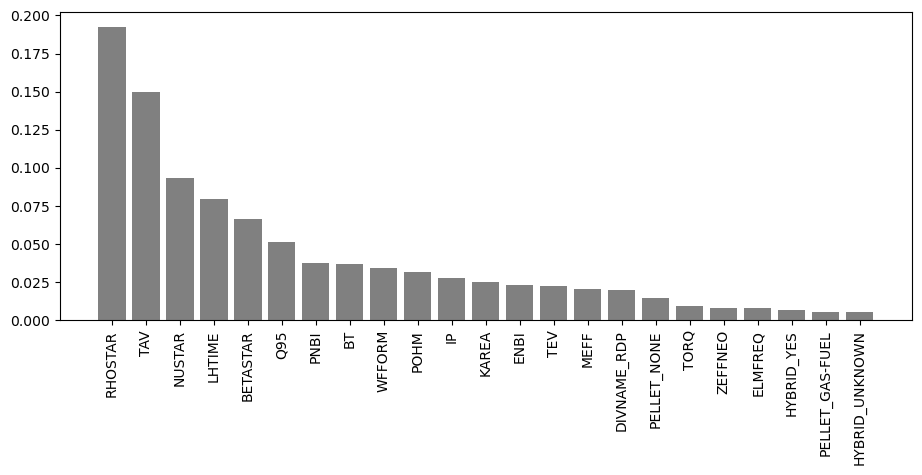

In [59]:
plt.figure(figsize=(11,4))
plt.bar(df[df.importance > 0.5e-2].feature, df[df.importance > 0.5e-2].importance, color="gray")
plt.xticks(rotation=90);

# Permutation Feature Importance

In [60]:
n_permutations = 100
feature_importance = np.zeros(X_train.shape[1])

recall = precision_recall_fscore_support(y_test, y_pred_, labels=[1,0])[1][0]

for i in range(X_train.shape[1]):
    recall_diffs = np.zeros(n_permutations)
    for j in range(n_permutations):
        X_test_permuted = X_test.copy()
        X_test_permuted.iloc[:, i] = np.random.permutation(X_test.iloc[:, i])
        y_pred_permuted = rf.predict(X_test_permuted)
        recall_permuted = precision_recall_fscore_support(y_test, y_pred_permuted, labels=[1,0])[1][0]
        recall_diffs[j] = recall_permuted - recall
    feature_importance[i] = np.mean(recall_diffs)

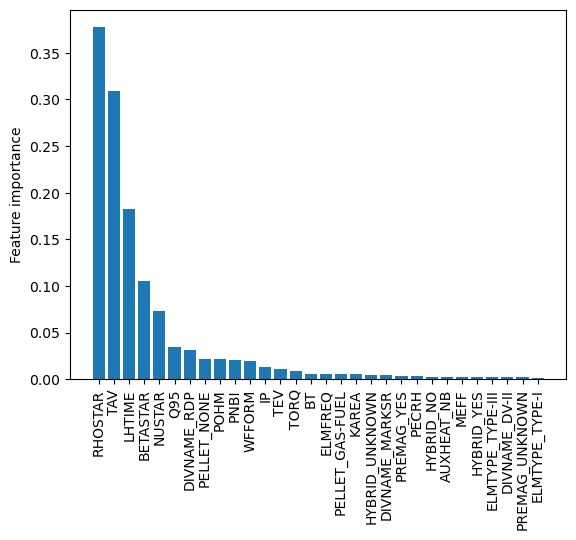

In [61]:
sorted_idx = np.argsort(abs(feature_importance))[::-1][:30]
plt.bar(range(len(sorted_idx)), abs(feature_importance[sorted_idx]))
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()

In [62]:
X_train.columns[sorted_idx]

Index(['RHOSTAR', 'TAV', 'LHTIME', 'BETASTAR', 'NUSTAR', 'Q95', 'DIVNAME_RDP',
       'PELLET_NONE', 'POHM', 'PNBI', 'WFFORM', 'IP', 'TEV', 'TORQ', 'BT',
       'ELMFREQ', 'PELLET_GAS-FUEL', 'KAREA', 'HYBRID_UNKNOWN',
       'DIVNAME_MARKSR', 'PREMAG_YES', 'PECRH', 'HYBRID_NO', 'AUXHEAT_NB',
       'MEFF', 'HYBRID_YES', 'ELMTYPE_TYPE-III', 'DIVNAME_DV-II',
       'PREMAG_UNKNOWN', 'ELMTYPE_TYPE-I'],
      dtype='object')

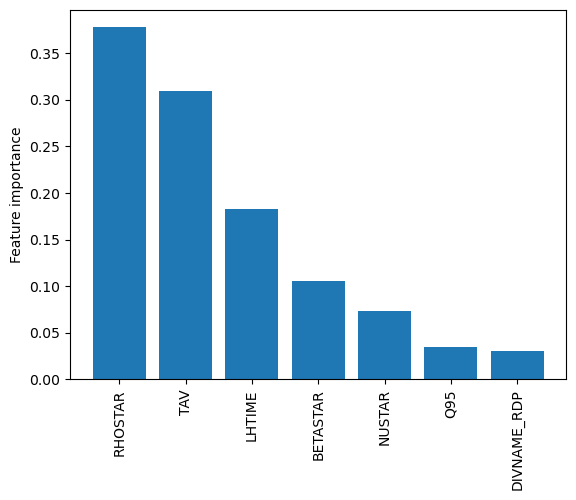

In [63]:
sorted_idx = np.argsort(abs(feature_importance))[::-1][:7]
plt.bar(range(len(sorted_idx)), abs(feature_importance[sorted_idx]))
plt.xticks(range(len(sorted_idx)), X_train.columns[sorted_idx], rotation=90)
plt.ylabel('Feature importance')
plt.show()

In [64]:
X_train.columns[sorted_idx]

Index(['RHOSTAR', 'TAV', 'LHTIME', 'BETASTAR', 'NUSTAR', 'Q95', 'DIVNAME_RDP'], dtype='object')